# Validation 
We will validate the model with a seperate dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json 
import h5py

In [2]:
class Result:
    def __init__(self,size) -> None:
        self.size=size
        with open(f'../Results/ADSB_Validation2/ADSB_{size}_big/Results/info', "r") as outfile:
            info =  json.load(outfile)
        self.acc = info['acc']
        self.th = info['th']
        data = np.load(f'../Results/ADSB_Validation2/ADSB_{size}_big/Results/final.npy',allow_pickle=True).item()

        self.anchors = data['anchor']
        self.test = data['test']
        self.loss = data['Loss']
        self.corr = data['Corr']
    
    def calculate_distance(self,a,b):
        return np.sum((a - b) ** 2,axis=1)
    
    def calculate_precision(self,nr_bits=32, uniform=True):
        if uniform:
            bits = [nr_bits]*self.size
        else:
            bits= self.get_bits_variane(nr_bits)

        anchors = self.quantize(self.anchors,bits)
        test = self.quantize(self.test,bits)
        idx_pos = self.corr>0.95

        loss = self.calculate_distance(anchors,test)
        hits = loss<self.th
        pn=np.sum(hits[idx_pos])/(np.sum(hits))
        return pn
    
    def calulate_hitrate(self,nr_bits=32):
        
        bits = [nr_bits]*self.size
      
        anchors = self.quantize(self.anchors,bits)
        test = self.quantize(self.test,bits)
        

        loss = self.calculate_distance(anchors,test)
        hits = loss<self.th
        pn=np.sum(hits)/len(hits)
        return pn
    
    def Normalize_features(self,nr_bits=32, uniform=True):
        if uniform:
            bits = [nr_bits]*self.size
        else:
            bits= self.get_bits_variane(nr_bits)

        anchors = self.quantize(self.anchors,bits)
        test = self.quantize(self.test,bits)

        idx_pos = self.corr>0.95

        loss = self.calculate_distance(anchors,test)
        hits = loss<self.th
        pn=np.sum(hits[idx_pos])/(np.sum(idx_pos))
        return pn


    def calculate_recall(self,nr_bits=32, uniform=True):
        if uniform:
            bits = [nr_bits]*self.size
        else:
            bits= self.get_bits_variane(nr_bits)

        anchors = self.quantize(self.anchors,bits)
        test = self.quantize(self.test,bits)

        idx_pos = self.corr>0.95

        loss = self.calculate_distance(anchors,test)
        hits = loss<self.th
        pn=np.sum(hits[idx_pos])/(np.sum(idx_pos))
        return pn
    
    def quantize_column(self,a,nr_bits):
        if nr_bits==0:
            return a*0
        levels = 2 ** nr_bits
        return np.round(a * (levels - 1))/(levels - 1)
    
    def quantize(self,a,nr_bits):
        assert len(nr_bits)==len(a[0])
        res = np.zeros_like(a)
        for i,n in enumerate(nr_bits):
            res[:,i] = self.quantize_column(a[:,i],n)
        return res 
   
    

In [ ]:
r = Result(26)
r_min = np.min(r.anchors,axis=0)
r_max = np.max(r.anchors,axis=0)

def norm(a,mi,ma):
    return (a-mi)/(ma-mi)

def denorm(a,mi,ma):
    return a*(ma-mi)+mi

a = r.anchors
b = r.test
d0 = r.calculate_distance(a,b)
d1 = r.calculate_distance(norm(a,r_min,r_max),norm(b,r_min,r_max))

l = 0
for i,j in zip(d0,d1):
    print(i,j)
    l+=1
    if l==5:
        break



0.2184856 2.8827043
0.41516772 2.9011762
0.0075480086 0.025761172
0.33781907 2.9903672
0.34698036 2.6574304


26 Recall:75.76,Precision:0.64,Hitrate:3.91
30 Recall:81.82,Precision:0.40,Hitrate:6.78


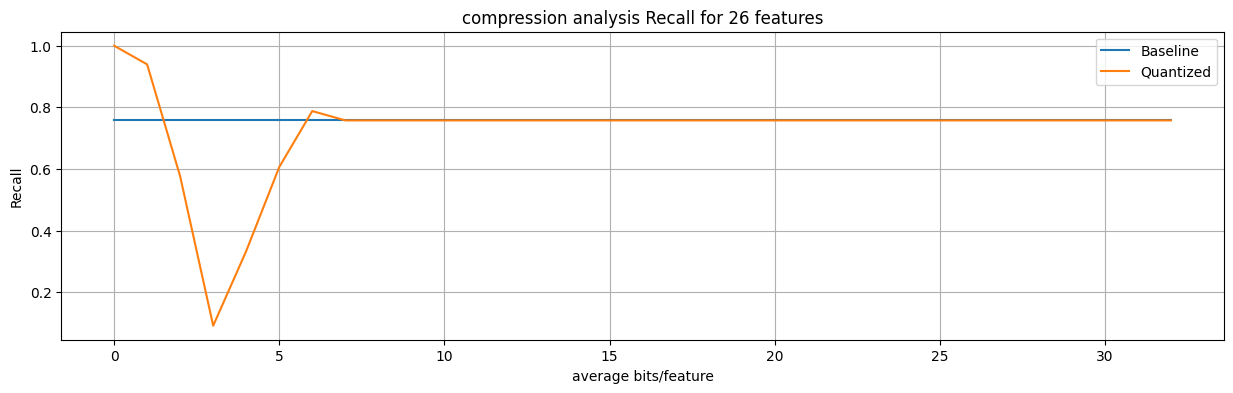

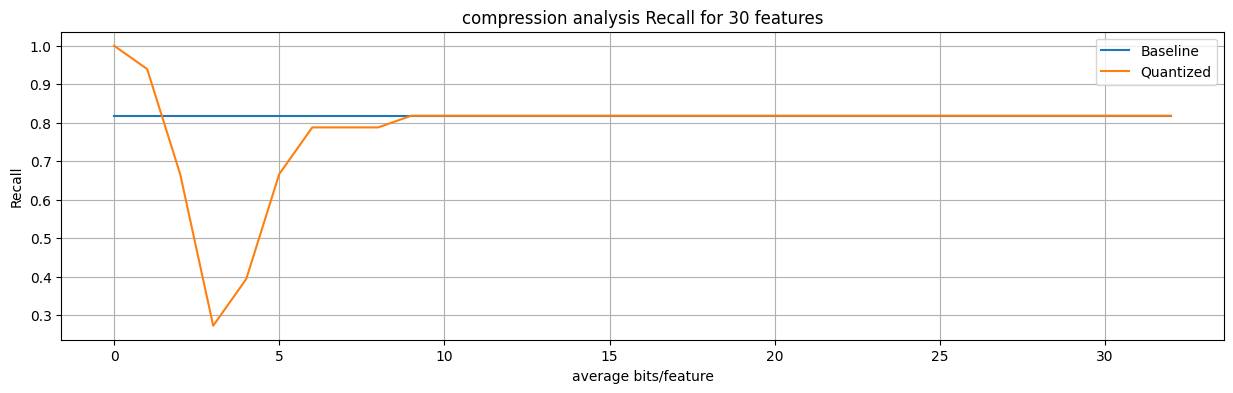

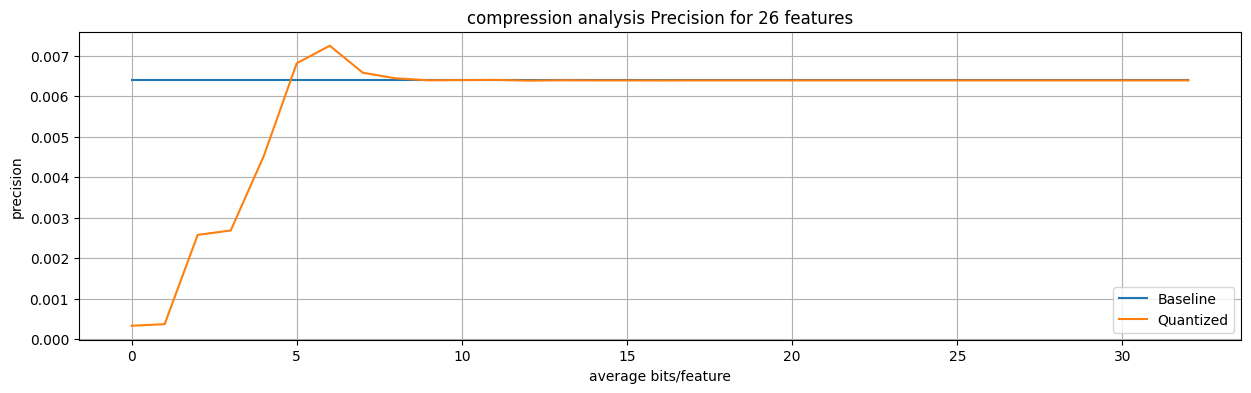

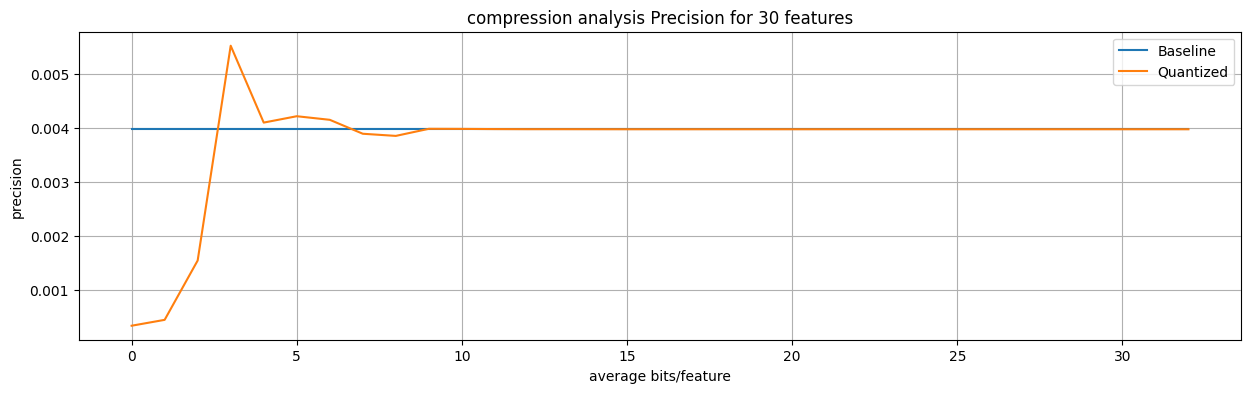

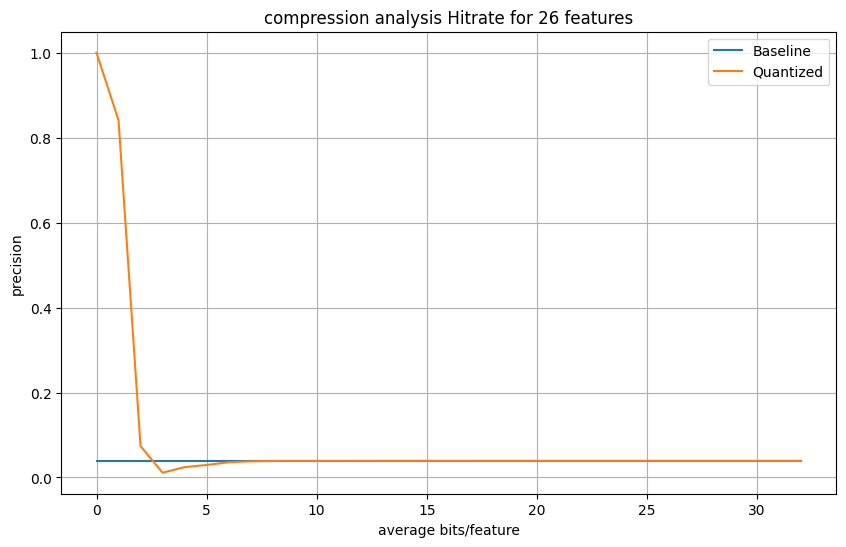

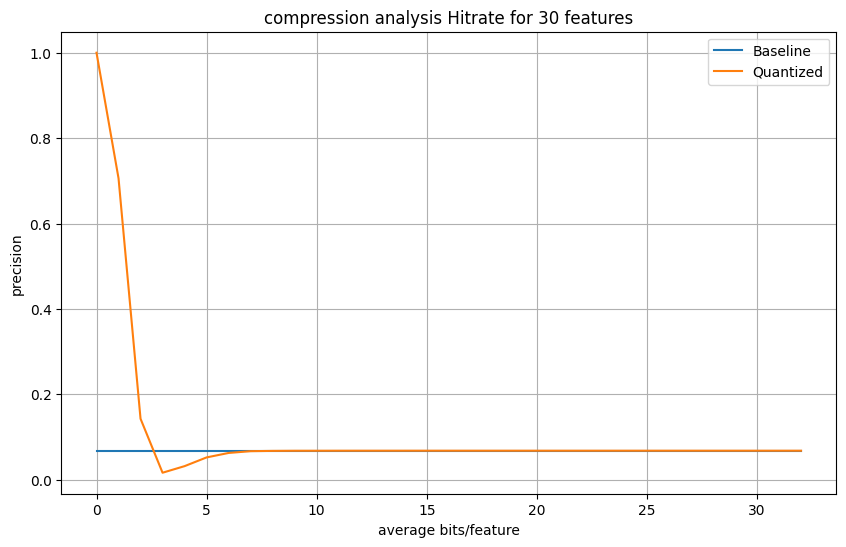

In [26]:
sizes = [26,30]
for s in sizes:
    r =Result(s)
    print(s,f'Recall:{r.calculate_recall()*100:.2f},Precision:{r.calculate_precision()*100:.2f},Hitrate:{r.calulate_hitrate()*100:.2f}')

for s in sizes:
    r = Result(s)
    bits = range(33)
    plt.figure(figsize=(15,4))
    plt.plot(bits,[r.calculate_recall(nr_bits=64) for b in bits],label='Baseline')
    plt.plot(bits,[r.calculate_recall(nr_bits=b) for b in bits],label='Quantized')
    # plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
    plt.grid()
    plt.xlabel('average bits/feature')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(f'compression analysis Recall for {s} features')
    plt.show()

for s in sizes:
    r = Result(s)
    bits = range(33)
    plt.figure(figsize=(15,4))
    plt.plot(bits,[r.calculate_precision(nr_bits=64) for b in bits],label='Baseline')
    plt.plot(bits,[r.calculate_precision(nr_bits=b) for b in bits],label='Quantized')
    # plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
    plt.grid()
    plt.xlabel('average bits/feature')
    plt.ylabel('precision')
    plt.legend()
    plt.title(f'compression analysis Precision for {s} features')
    plt.show()

for s in sizes:
    r = Result(s)
    bits = range(33)
    plt.figure(figsize=(10,6))
    plt.plot(bits,[r.calulate_hitrate(nr_bits=64) for b in bits],label='Baseline')
    plt.plot(bits,[r.calulate_hitrate(nr_bits=b) for b in bits],label='Quantized')
    # plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
    plt.grid()
    plt.xlabel('average bits/feature')
    plt.ylabel('precision')
    plt.legend()
    plt.title(f'compression analysis Hitrate for {s} features')
    plt.show()

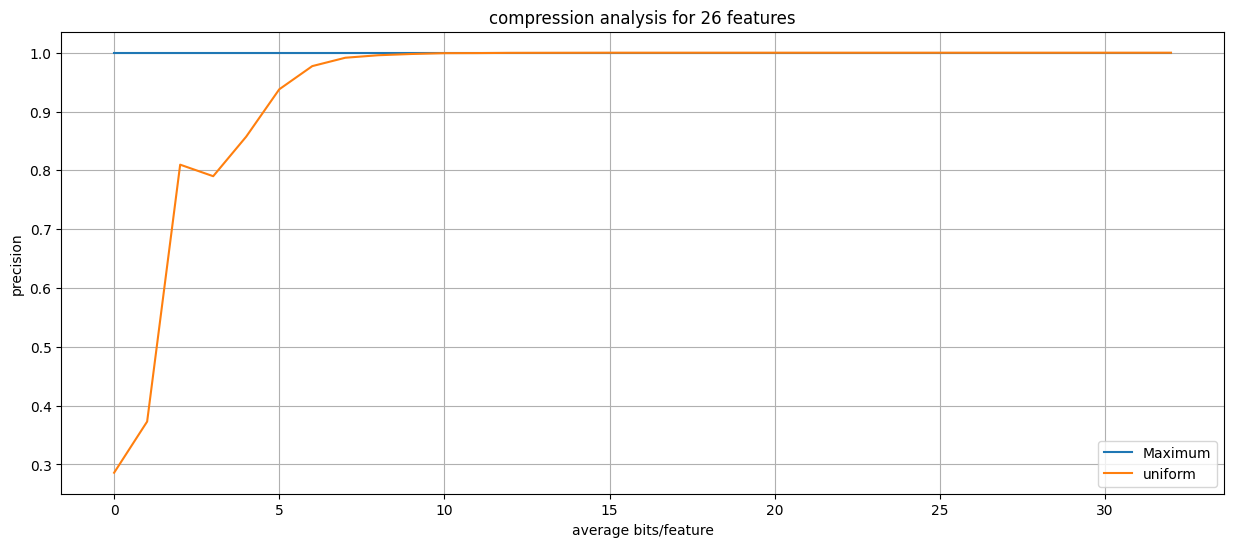

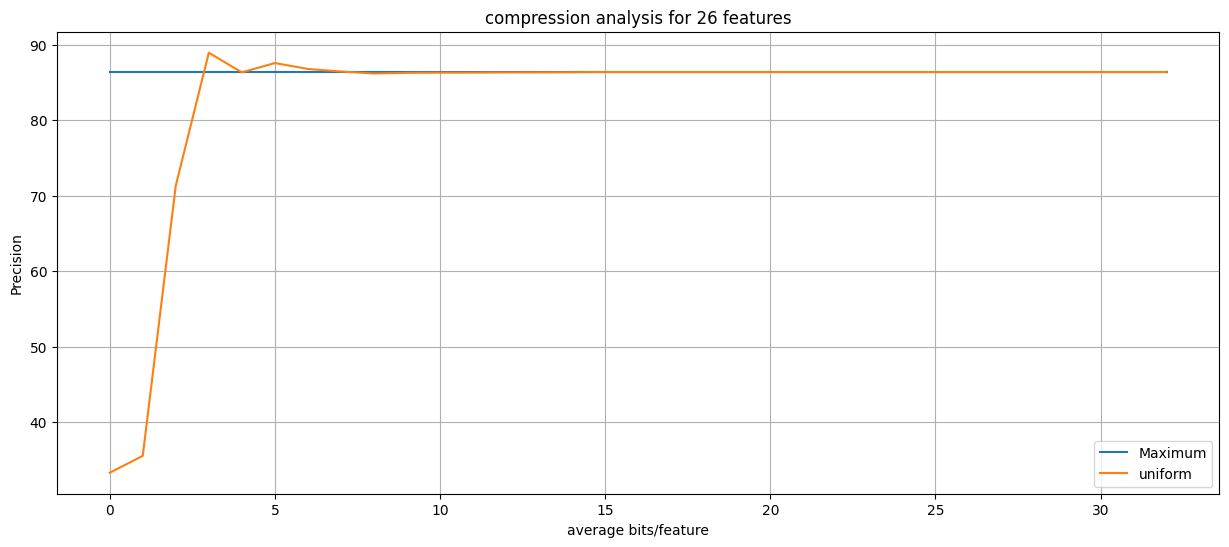

In [165]:
# What is the percentage of data that is estimated differently now. 
# recall == different result 
s = 26
r = Result(s)
bits = range(33)
plt.figure(figsize=(15,6))
plt.plot(bits,[r.calculate_recall(nr_bits=64) for b in bits],label='Maximum')
plt.plot(bits,[r.calculate_recall(nr_bits=b) for b in bits],label='uniform')
# plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
plt.grid()
plt.xlabel('average bits/feature')
plt.ylabel('precision')
plt.legend()
plt.title(f'compression analysis for {s} features')
plt.show()

s = 26
r = Result(s)
bits = range(33)
plt.figure(figsize=(15,6))
plt.plot(bits,[r.calculate_accuracy(nr_bits=64) for b in bits],label='Maximum')
plt.plot(bits,[r.calculate_accuracy(nr_bits=b) for b in bits],label='uniform')
# plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
plt.grid()
plt.xlabel('average bits/feature')
plt.ylabel('Precision')
plt.legend()
plt.title(f'compression analysis for {s} features')
plt.show()


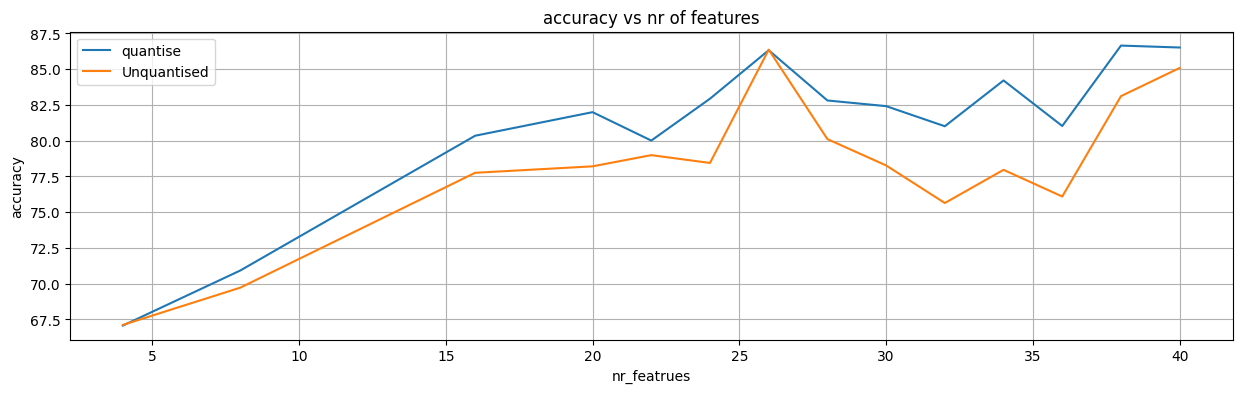

In [98]:



acc = []
acc_orf = []
sizes= [4,8,16,20,22,24,26,28,30,32,34,36,38,40]
for s in sizes:
    r = Result(s)
    acc_orf.append(r.calculate_accuracy(nr_bits=32))
    acc.append(r.calculate_accuracy(nr_bits=4))


plt.figure(figsize=(15, 4))
plt.plot(sizes,acc,label='quantise')
plt.plot(sizes,acc_orf,label='Unquantised')
plt.title('accuracy vs nr of features')
plt.xlabel('nr_featrues')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()



In [152]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Example data (rows = samples, columns = features)
r = Result(4)

print(r.get_bits_variane(16))



(array([25,  6, 29,  4]), array([0.39517784, 0.09457856, 0.45227686, 0.05796675], dtype=float32))


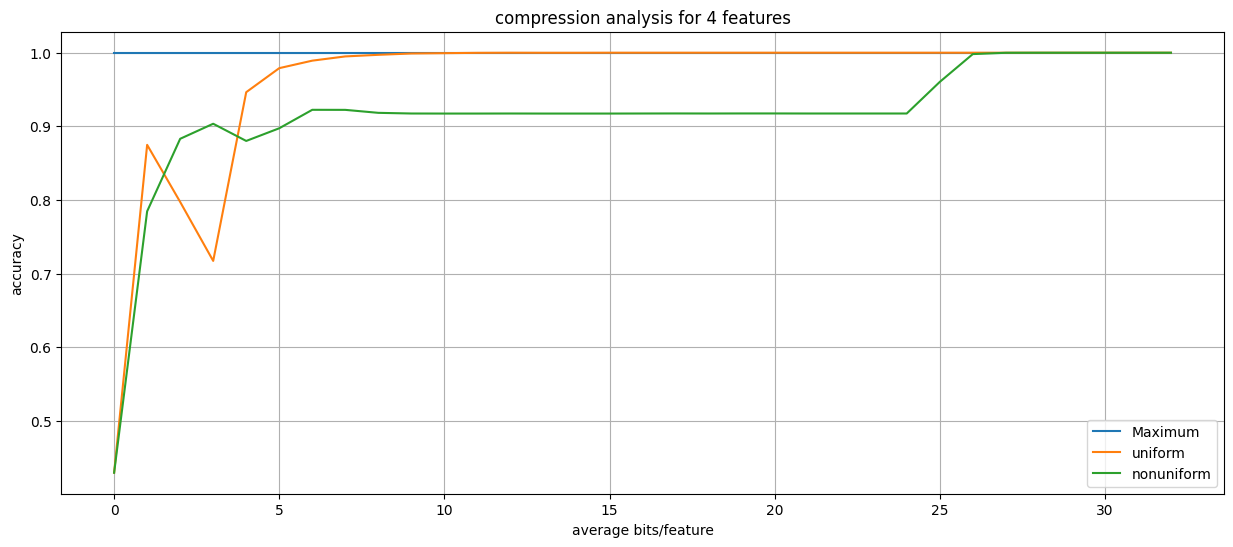

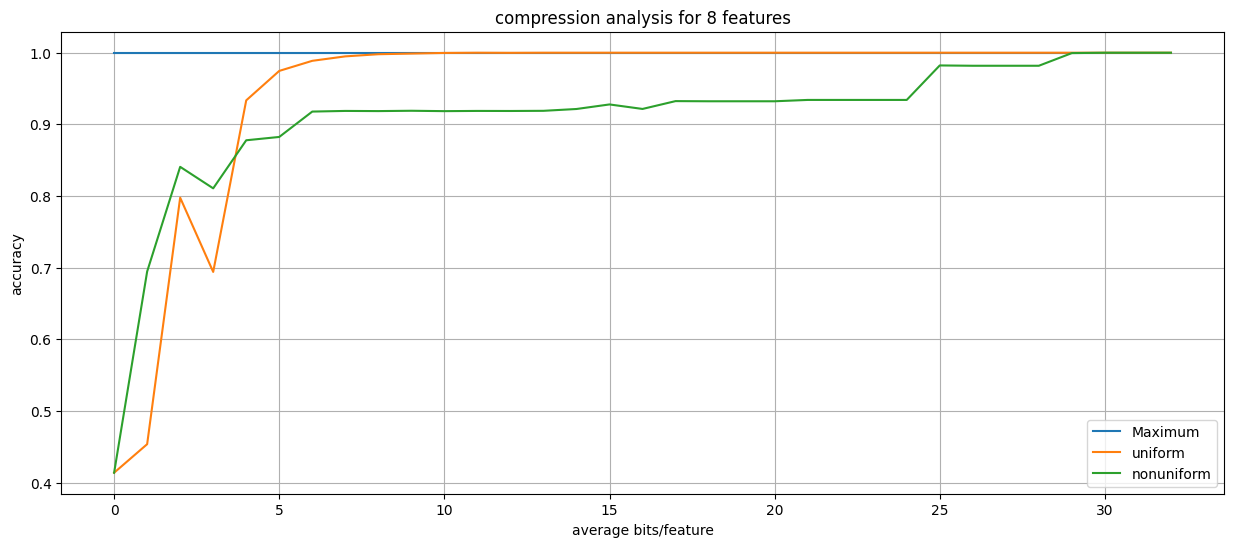

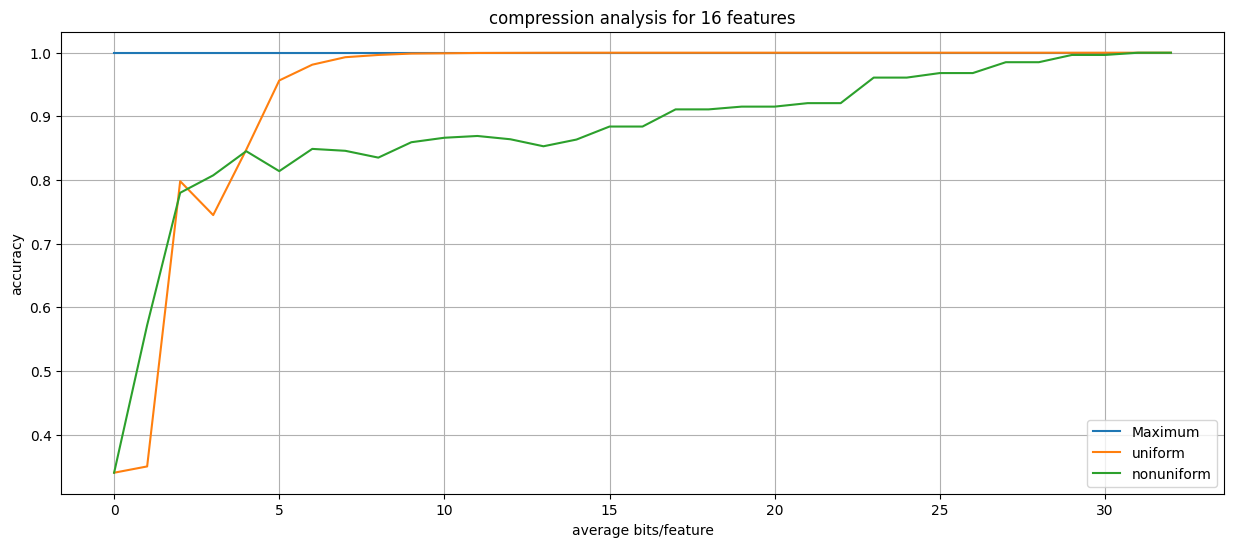

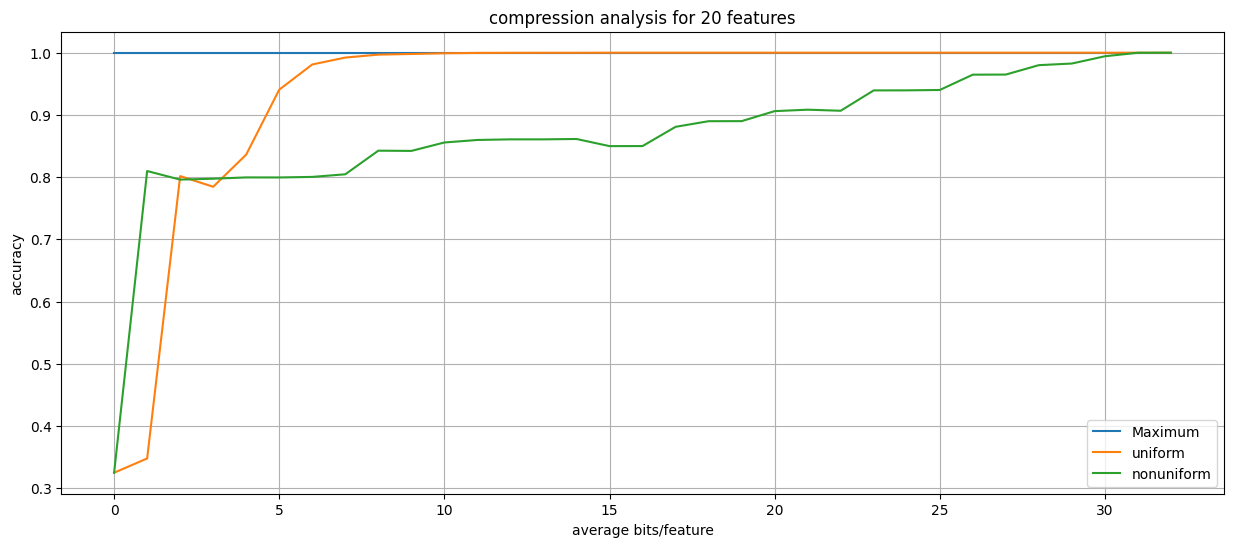

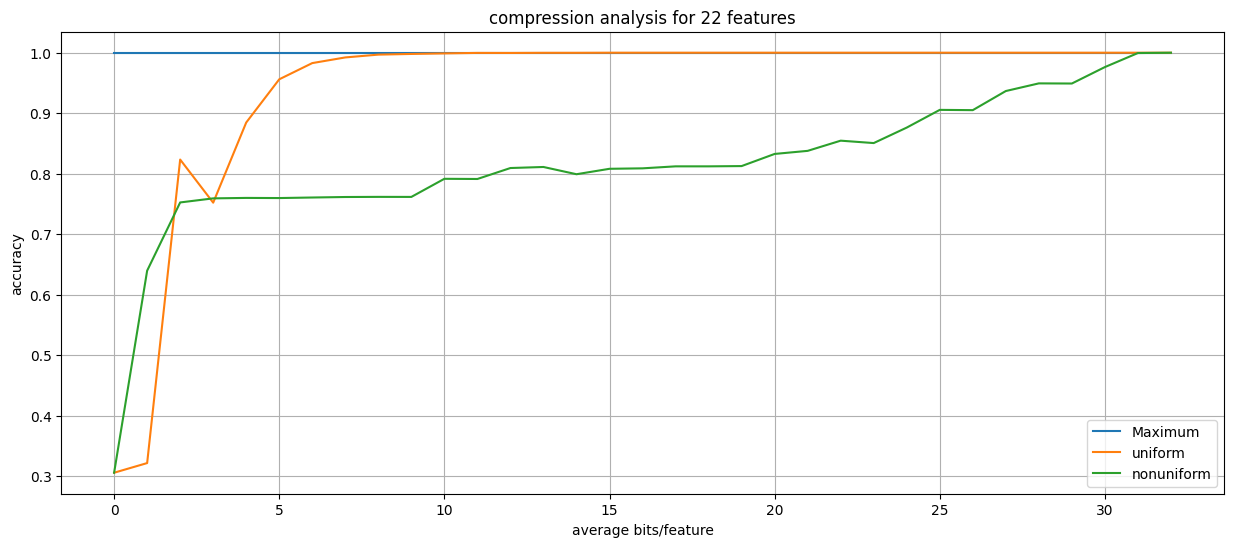

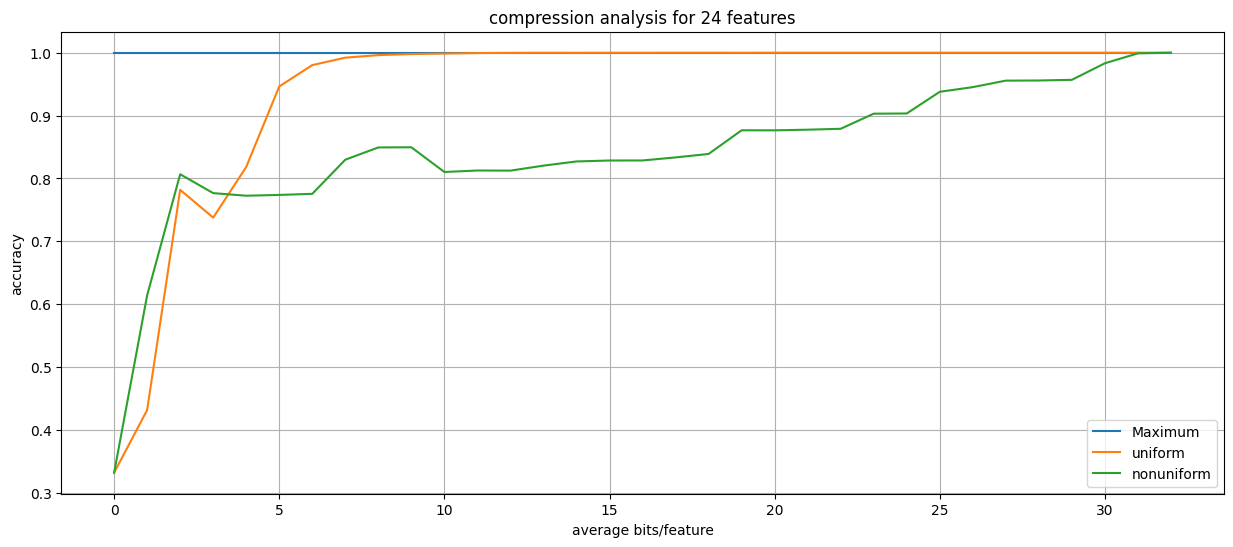

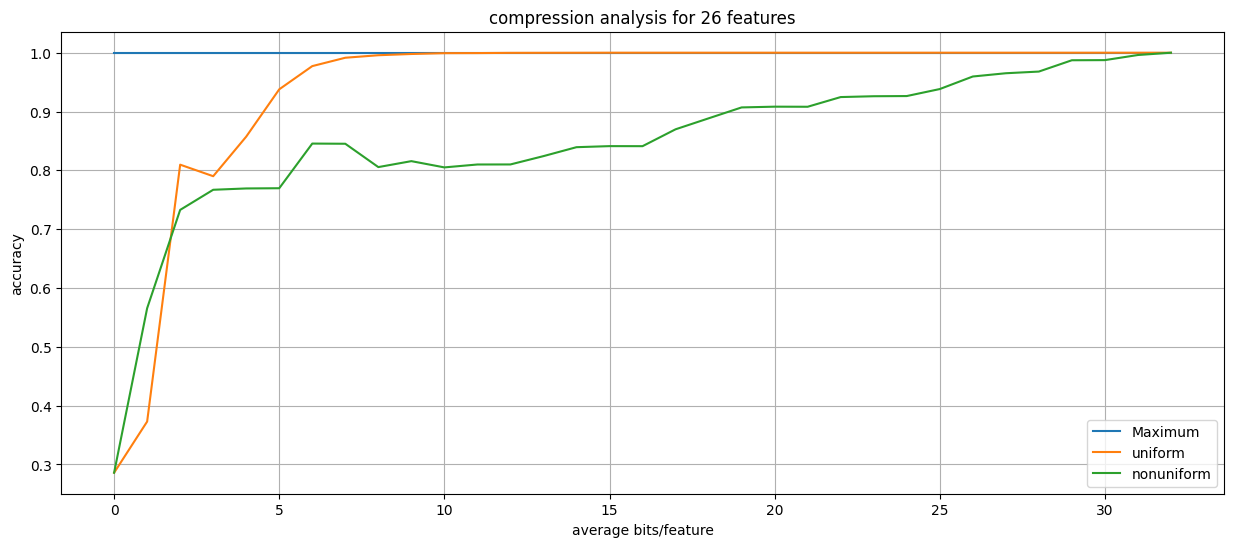

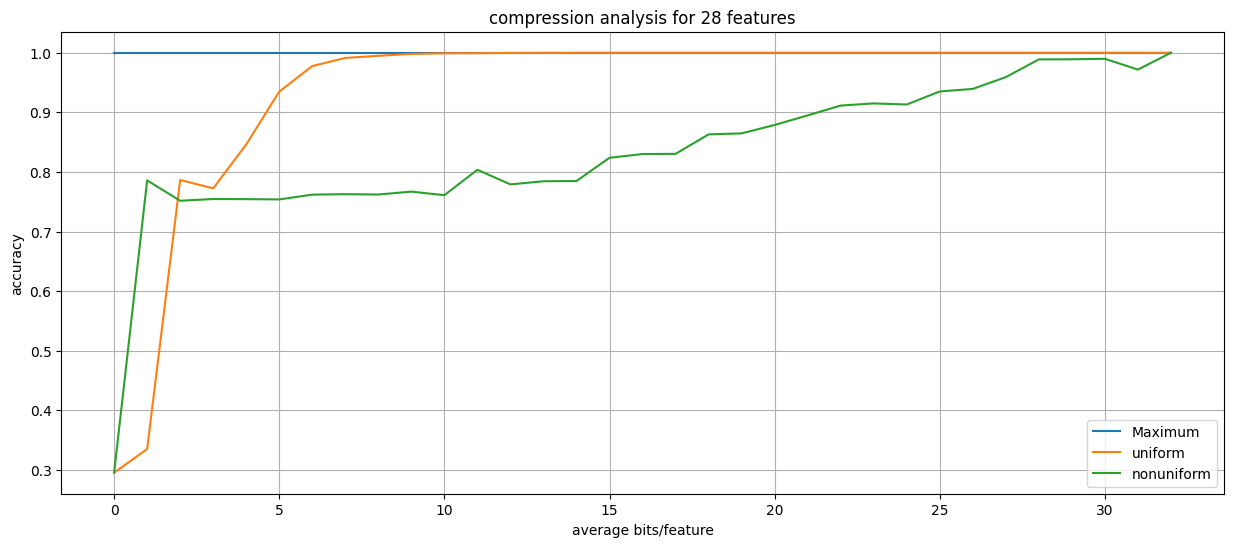

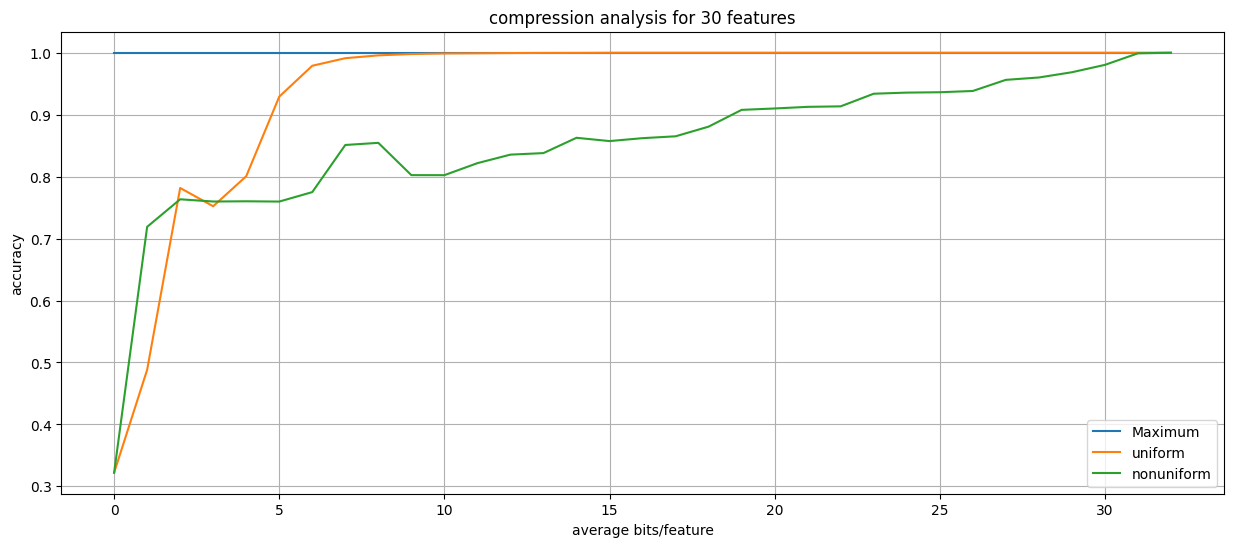

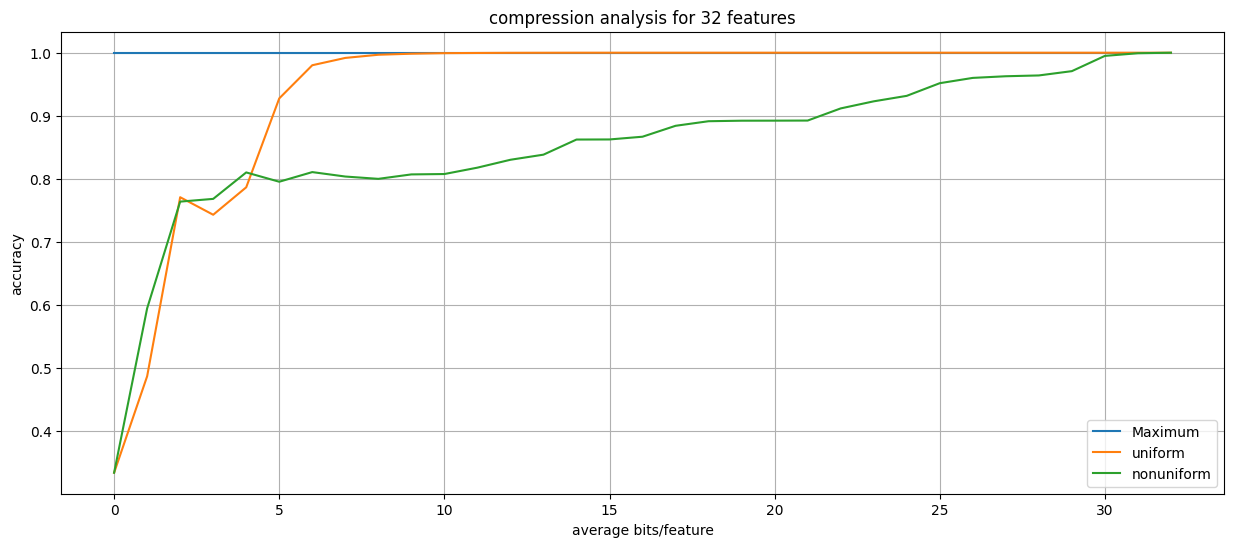

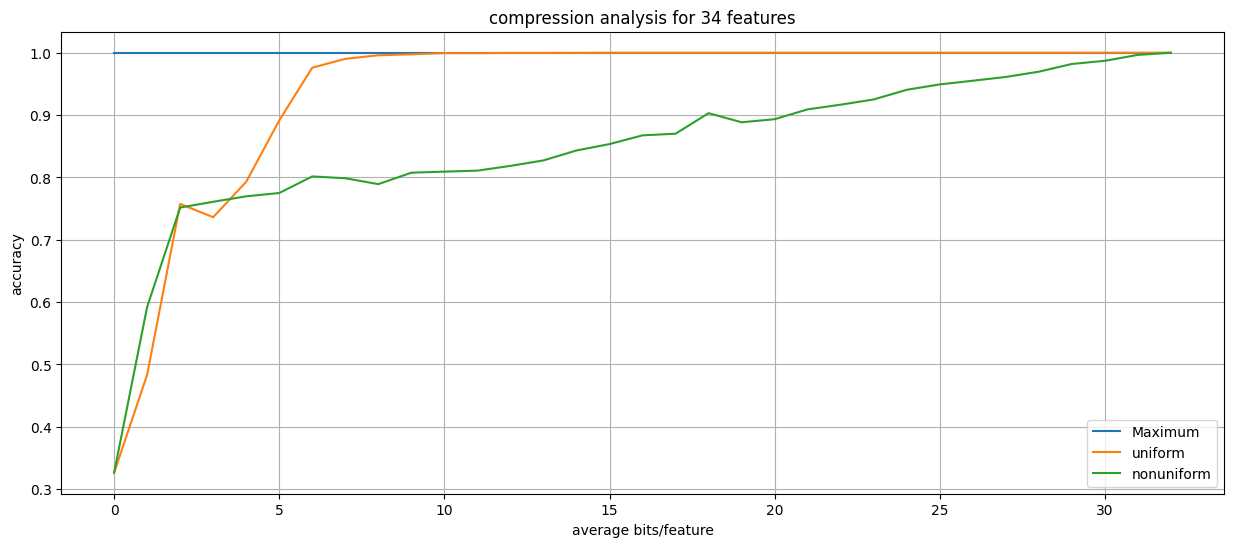

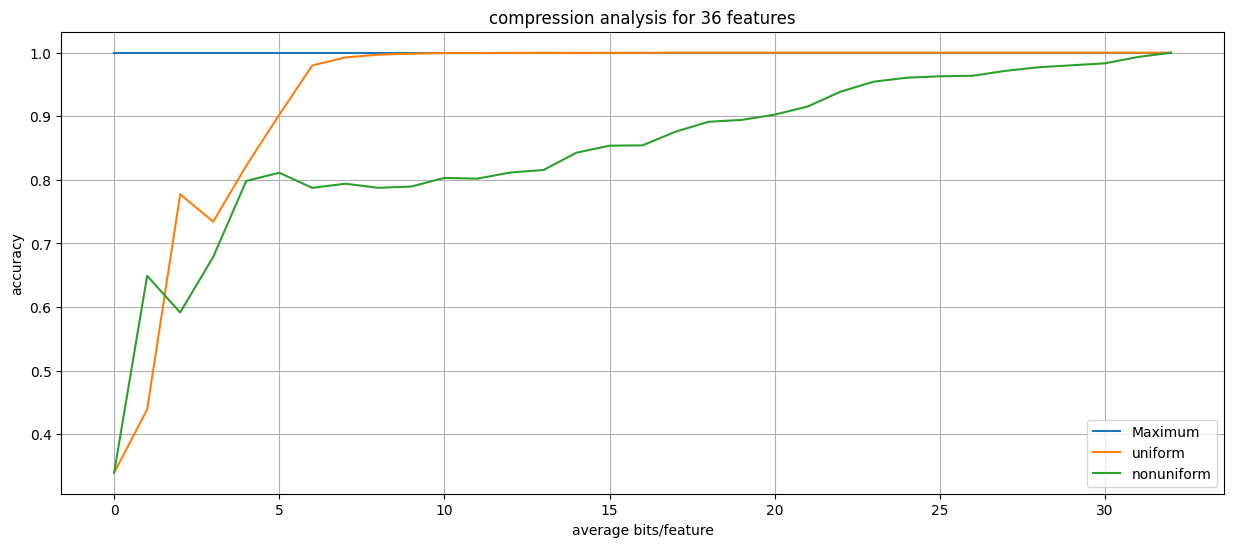

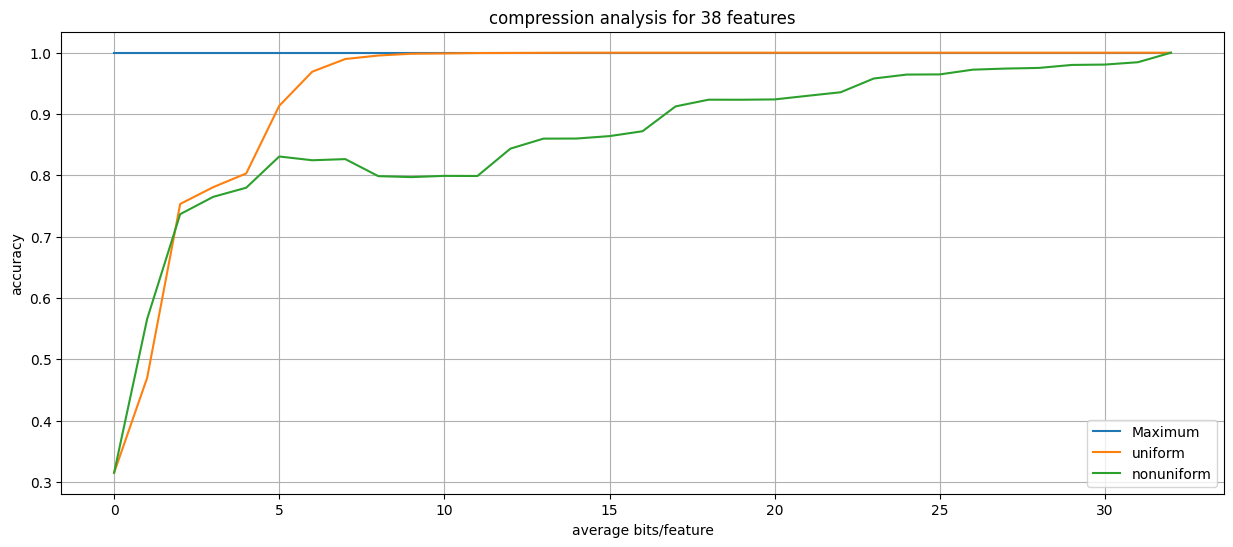

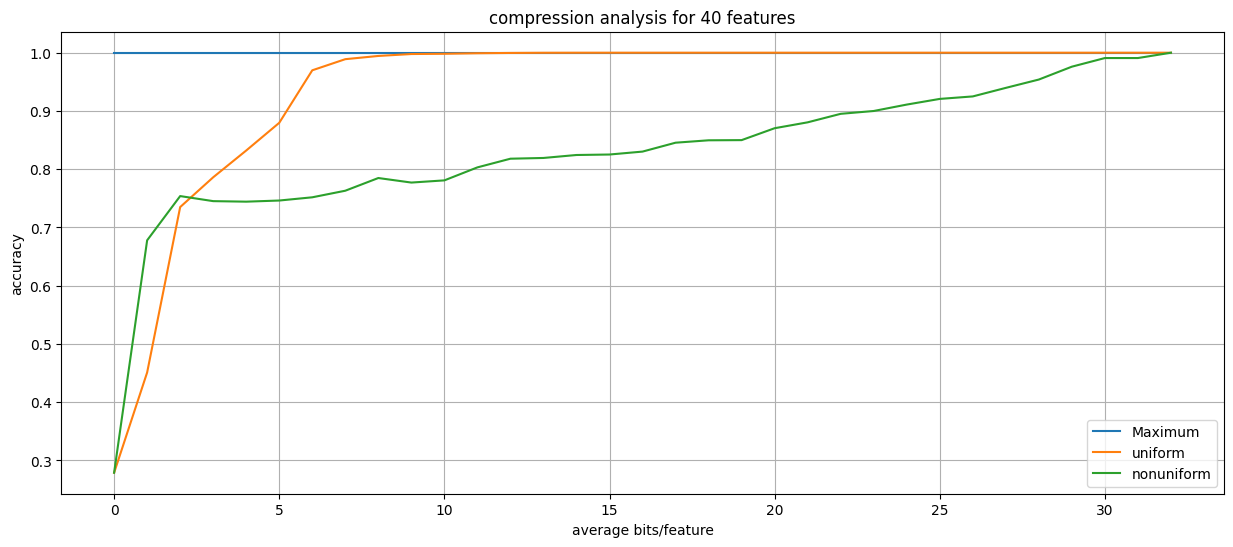

In [124]:
for s in sizes:
    r = Result(s)
    bits = range(33)
    plt.figure(figsize=(15,6))
    plt.plot(bits,[r.calculate_recall(nr_bits=64) for b in bits],label='Maximum')
    plt.plot(bits,[r.calculate_recall(nr_bits=b) for b in bits],label='uniform')
    plt.plot(bits,[r.calculate_recall(nr_bits=b,uniform=False) for b in bits],label='nonuniform')
    plt.grid()
    plt.xlabel('average bits/feature')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title(f'compression analysis for {s} features')
    plt.show()